In [12]:
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import unidecode
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("C:\\Users\\MGC\\PycharmProjects\\mlquestion8\\mlquestion8\\train.csv\\train.csv")

### Preprocessing the data 

In [3]:
train.replace(np.nan, " ", inplace= True)

In [4]:
def case_convert():
    train.question1 = [i.lower() for i in train.question1]
    train.question2 = [i.lower() for i in train.question2]


def remove_specials():
    train.question1 = [re.sub(r"[^a-zA-Z]", " ", text) for text in train.question1]
    train.question2 = [re.sub(r"[^a-zA-Z]", " ", text) for text in train.question2]
    

def remove_stopwords():
    texts = []
    stopwords_list = stopwords.words('english')
    for item in train.question1:
        string = ""
        for word in item.split(" "):
            if word.strip() in stopwords_list:
                continue
            else:
                string = string + " " + word
        texts.append(string)
    train.question1 = texts
    texts.clear()
    for item in train.question2:
        string = ""
        for word in item.split(" "):
            if word.strip() in stopwords_list:
                continue
            else:
                string = string + " " + word
        texts.append(string)
    train.question2 = texts
    texts.clear()
    

def remove_accents():
    train.question1 = [unidecode.unidecode(text) for text in train.question1]
    train.question2 = [unidecode.unidecode(text) for text in train.question2]
    
def normalize_spaces():
    train.question1 = [re.sub(r"\s+", " ", text) for text in train.question1]
    train.question2 = [re.sub(r"\s+", " ", text) for text in train.question2]
    

In [5]:
case_convert()
remove_accents()
remove_specials()
remove_stopwords()
normalize_spaces()

In [14]:
#word len
train['q1_len']=train['question1'].str.len()
train['q2_len']=train['question2'].str.len()

#word count
train['q1_word']=train['question1'].apply(lambda x: len(x.split(" ")))
train['q2_word']=train['question2'].apply(lambda x: len(x.split(" ")))


#common words

train['s1']=train['question1'].apply(lambda x: x.split(" "))
train['s2']=train['question1'].apply(lambda x: x.split(" "))
train['common_words']= [len(set(a) & set(b)) for a, b in zip(train.s1, train.s2)]
train.drop(['s1','s2'],axis=1,inplace=True)


#common words share

train['word_share_q1']=round(train['common_words']/train['q1_word'],2)
train['word_share_q2']=round(train['common_words']/train['q2_word'],2)

### Visualization

C:\Users\MGC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\MGC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


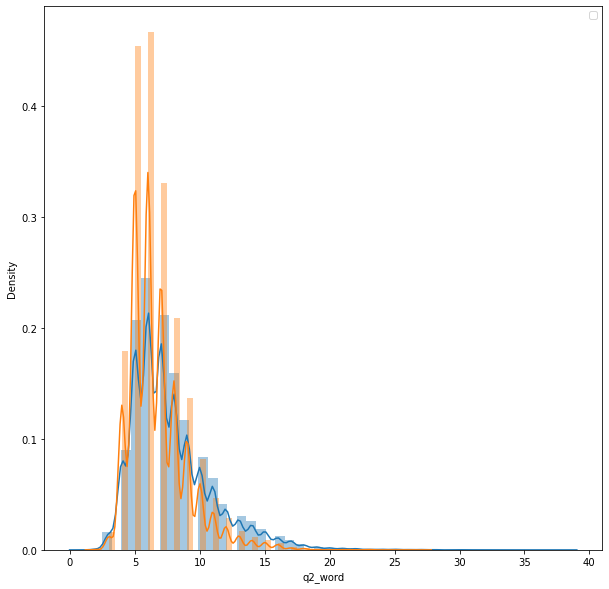

In [15]:
plt.figure(figsize=(10,10))
sns.distplot(train[train['is_duplicate']==0]['q1_word'])
sns.distplot(train[train['is_duplicate']==1]['q2_word'])
plt.legend()
plt.show()

C:\Users\MGC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\MGC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


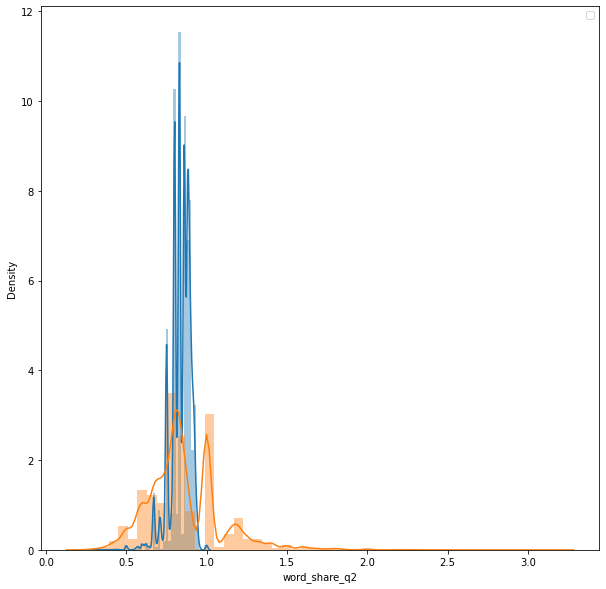

In [16]:
plt.figure(figsize=(10,10))
sns.distplot(train[train['is_duplicate']==0]['word_share_q1'])
sns.distplot(train[train['is_duplicate']==1]['word_share_q2'])
plt.legend()
plt.show()

Minimum length: 0
Maximum length: 284
Average length: 38


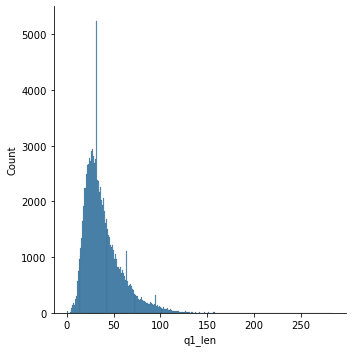

In [18]:
sns.displot(train['q1_len'])
print('Minimum length:', train['q1_len'].min())
print('Maximum length:', train['q1_len'].max())
print('Average length:', int(train['q1_len'].mean()))

In [6]:
train = train.sample(100000, replace=True)

In [7]:
x = train.drop(['is_duplicate'], axis=1)
y = train['is_duplicate']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

### Mapping the words in the questions using TF-IDF

In [8]:
vector = TfidfVectorizer(max_features=5000)
train_df = vector.fit_transform(x_train['question1'] + ' ' + x_train['question2']).toarray()
test_df = vector.fit_transform(x_test['question1']+ ' ' + x_test['question2'] ).toarray()
x_train = x_train.drop(['question1', 'question2'], axis=1)
x_test = x_test.drop(['question1', 'question2'], axis=1)
x_train = np.concatenate([x_train.to_numpy(), train_df], axis=1)
x_test = np.concatenate([x_test.to_numpy(), test_df], axis=1)

### Model training and evaluation

In [10]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
prediction = lr.predict(x_test)
print(classification_report(prediction, y_test))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81     26863
           1       0.38      0.75      0.50      6137

    accuracy                           0.73     33000
   macro avg       0.65      0.73      0.66     33000
weighted avg       0.82      0.73      0.75     33000



In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(prediction, y_test)

0.726